# 3장 텐서 구조체

텐서는 일종의 배열이다. 인덱스를 통해 개별적으로 값에 접근할 수 있다.

In [1]:
a = [1.0, 2.0, 3.0]
a[0]

1.0

In [2]:
a[2]

3.0

텐서는 리스트보다 효율적이고 알아보기 쉽게 데이터를 조작할 수 있다

In [3]:
import torch
a = torch.ones(3)
a

tensor([1., 1., 1.])

In [4]:
a[1]

tensor(1.)

In [5]:
float(a[1])

1.0

In [6]:
a[2] = 2.0
a

tensor([1., 1., 2.])

In [8]:
points = torch.zeros(6) 
points[0] = 4.0 
points[1] = 1.0
points[2] = 5.0
points[3] = 3.0
points[4] = 2.0
points[5] = 1.0

생성자에 파이썬 리스트를 넘겨도 된다

In [9]:
points = torch.tensor([4.0, 1.0, 5.0, 3.0, 2.0, 1.0])
points

tensor([4., 1., 5., 3., 2., 1.])

In [10]:
float(points[0]), float(points[1])

(4.0, 1.0)

2차원 좌표로 표현할 수 있다

In [11]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

텐서의 차원과 크기를 shape 함수로 알 수 있다

In [12]:
points.shape

torch.Size([3, 2])

In [13]:
points = torch.zeros(3, 2)
points

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [14]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

텐서[0차원 axis, 1차원 axis]로 개별적으로 접근할 수 있다

In [15]:
points[0, 1]

tensor(1.)

In [16]:
points[0]

tensor([4., 1.])

앞 장에서 봤던 img_t 3차원 텐서로 표현할 수 있다

In [7]:
img_t = torch.randn(3, 5, 5) # shape [channels, rows, columns]
weights = torch.tensor([0.2126, 0.7152, 0.0722])

배치 사이즈를 2로 설정하고 새로운 텐서를 생성한다

In [3]:
batch_t = torch.randn(2, 3, 5, 5) # shape [batch, channels, rows, columns]

두 텐서 모두 rgb 채널이 뒤에서 3번쨰에 위치하기 때문에 -3번쨰 차원에 대해 일반화를 해준다

In [4]:
img_gray_naive = img_t.mean(-3)
batch_gray_naive = batch_t.mean(-3)
img_gray_naive.shape, batch_gray_naive.shape

(torch.Size([5, 5]), torch.Size([2, 5, 5]))

### tensor.view()
torch.view()함수를 사용해서 텐서의 크기를 변경할 수 있다. torch.view([-1, 1, 3])과 같이 차원을 입력해주면 크기를 변경 가능하다
### tensor.squeeze()
tensor.squeeze() 함수로 1인 차원을 제거할 제거한다. shape이 [3, 1]인 경우 [3,]으로 바뀐다
### tensor.unsqueeze()
tensor.unsqueeze()함수로 특정 차원에 1인 차원을 추가할 수 있다. 인덱스를 인자로 넣어주면 인덱스 axis에 새로운 차원을 추가한다.


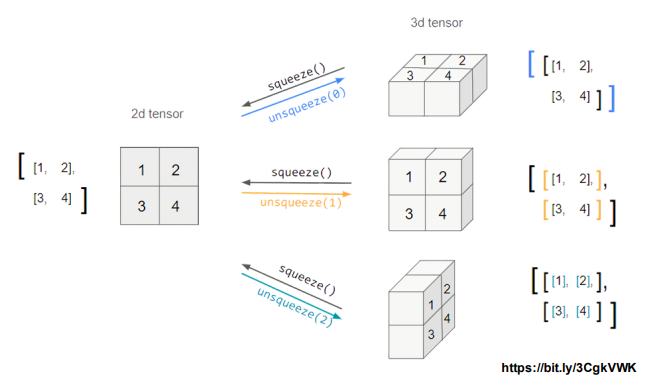

In [5]:
unsqueezed_weights = weights.unsqueeze(-1).unsqueeze_(-1) # 브로드캐스팅
img_weights = (img_t * unsqueezed_weights)
batch_weights = (batch_t * unsqueezed_weights)
img_gray_weighted = img_weights.sum(-3)
batch_gray_weighted = batch_weights.sum(-3)
batch_weights.shape, batch_t.shape, unsqueezed_weights.shape

(torch.Size([2, 3, 5, 5]), torch.Size([2, 3, 5, 5]), torch.Size([3, 1, 1]))

In [6]:
img_gray_weighted_fancy = torch.einsum('...chw,c->...hw', img_t, weights)
batch_gray_weighted_fancy = torch.einsum('...chw,c->...hw', batch_t, weights)
batch_gray_weighted_fancy.shape

torch.Size([2, 5, 5])

파이토치 1.3버전에서는 텐서에 이름을 지정할 수 있다.

In [7]:
weights_named = torch.tensor([0.2126, 0.7152, 0.0722], names=['channels'])
weights_named

tensor([0.2126, 0.7152, 0.0722], names=('channels',))

In [8]:
img_named =  img_t.refine_names(..., 'channels', 'rows', 'columns')
batch_named = batch_t.refine_names(..., 'channels', 'rows', 'columns')
print("img named:", img_named.shape, img_named.names)
print("batch named:", batch_named.shape, batch_named.names)

img named: torch.Size([3, 5, 5]) ('channels', 'rows', 'columns')
batch named: torch.Size([2, 3, 5, 5]) (None, 'channels', 'rows', 'columns')


브로드캐스팅이 될 때 어느 차원이 1로 브로드캐스팅 될건지 align_as 함수로 직접 지정해준다. 

In [9]:
weights_aligned = weights_named.align_as(img_named)
weights_aligned.shape, weights_aligned.names

(torch.Size([3, 1, 1]), ('channels', 'rows', 'columns'))

In [10]:
gray_named = (img_named * weights_aligned).sum('channels')
gray_named.shape, gray_named.names

(torch.Size([5, 5]), ('rows', 'columns'))

이름이 다른 차원끼리 결합하면 오류가 발생한다.

In [11]:
try:
    gray_named = (img_named[..., :3] * weights_named).sum('channels')
except Exception as e:
    print(e)

Error when attempting to broadcast dims ['channels', 'rows', 'columns'] and dims ['channels']: dim 'columns' and dim 'channels' are at the same position from the right but do not match.


함수 외에서 사용하려면 이름을 None으로 초기화해줘야 한다

In [12]:
gray_plain = gray_named.rename(None)
gray_plain.shape, gray_plain.names

(torch.Size([5, 5]), (None, None))

Tensor 객체는 실제로는 Storage 인스턴스에 대한 뷰다. points 텐서도 사실 6개의 배열 공간일 뿐이다.

In [17]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.FloatStorage of size 6]

따라서 tensor.storage()[idx]로 바로 접근 가능하다.

In [18]:
points_storage = points.storage()
points_storage[0]

4.0

In [19]:
points.storage()[1]

1.0

따라서 storage 인스턴스를 직접 수정하면 값이 바뀐다. 

In [20]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points_storage = points.storage()
points_storage[0] = 2.0
points

tensor([[2., 1.],
        [5., 3.],
        [2., 1.]])

저장되어 있는 tensor를 바꾸는 연산은 zero_처럼 밑줄로 끝난다. zero_()는 기존 텐서의 모든 요소를 0으로 바꾼다

In [8]:
a = torch.ones(3, 2)
a.zero_()
a

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

## 텐서의 메타데이터
### 사이즈
텐서의 사이즈는 넘파이에서 shape랑 같다. 텐서의 각 차원별로 들어가는 요소의 수를 표시한 튜플이다.
### 오프셋
저장 공간에 대한 오프셋은 텐서의 첫번째 요소를 가리키는 색인 값과 동일하다. 밑의 예제는 첫 포인트의 값 두개 다음이므로 오프셋 2에 해당하는 위치에 있다.
### 스트라이드
각 차원에서 다음 요소를 가리키고 싶을 때 실제 저장공간상에서 몇 개의 요소를 건너뛰어야 되는지 알려주는 숫자다. 밑의 예제에서는 튜플 형태로 각 차원에 대하여 인덱스를 하나 증가 했을때 실제 저장 공간상에는 몇 개 요소를 건너뛰어야하는지 알려준다.

In [21]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1]
second_point.storage_offset()

2

In [22]:
second_point.size()

torch.Size([2])

In [23]:
second_point.shape

torch.Size([2])

In [24]:
points.stride()

(2, 1)

새 텐서가 원래 points 텐서보다 하나 작은 차원을 가지지만 저장공간은 동일하다. 그래서 새 텐서의 요소를 바꿔도 points텐서의 값도 바뀐다. 

In [25]:
second_point = points[1]
second_point.size()

torch.Size([2])

In [26]:
second_point.storage_offset()

2

In [27]:
second_point.stride()

(1,)

In [28]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1]
second_point[0] = 10.0
points

tensor([[ 4.,  1.],
        [10.,  3.],
        [ 2.,  1.]])

파이썬의 copy deepcopy처럼, 새로운 텐서를 clone하고 서브텐서를 새 텐서로 복제할 수 있다.

In [29]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1].clone()
second_point[0] = 10.0
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [30]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

이제 전치를 다른 개념으로 생각해보면, stride가 (3, 1)이었다면 (1, 3)이 되어서 새로운 텐서를 만든다고 생각할 수 있다. storage 인스턴스에는 변화가 없으므로 둘은 같은 저장 공간을 가르킨다.

In [31]:
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [32]:
id(points.storage()) == id(points_t.storage())

True

In [33]:
points.stride()

(2, 1)

In [34]:
points_t.stride()

(1, 2)

In [35]:
some_t = torch.ones(3, 4, 5)
transpose_t = some_t.transpose(0, 2)
some_t.shape

torch.Size([3, 4, 5])

In [36]:
transpose_t.shape

torch.Size([5, 4, 3])

In [37]:
some_t.stride()

(20, 5, 1)

In [38]:
transpose_t.stride()

(1, 5, 20)

앞에서 points는 저장공간에 있는 데이터를 시작에서 증가하는 형태로 참조하는 형태로 contiguous하지만, 이를 전치한 값은 띄엄 띄엄 참조하므로 contiguous하지 않다. 인접한 텐서는 데이터 지역성 관점에서 CPU 메모리 접근 효율이 좋다.

In [39]:
points.is_contiguous()

True

In [40]:
points_t.is_contiguous()

False

In [41]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [42]:
points_t.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.FloatStorage of size 6]

In [43]:
points_t.stride()

(1, 2)

tensor.contiguous 함수로 인접한 텐서로 바꿀 수 있다. Contiguous 함수를 사용하면 텐서의 stride와 값의 배치가 바뀐 텐서가 만들어진다.

In [44]:
points_t_cont = points_t.contiguous()
points_t_cont

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [45]:
points_t_cont.stride()

(3, 1)

In [46]:
points_t_cont.storage()

 4.0
 5.0
 2.0
 1.0
 3.0
 1.0
[torch.FloatStorage of size 6]

In [47]:
double_points = torch.ones(10, 2, dtype=torch.double)
short_points = torch.tensor([[1, 2], [3, 4]], dtype=torch.short)

In [48]:
short_points.dtype

torch.int16

In [49]:
double_points = torch.zeros(10, 2).double()
short_points = torch.ones(10, 2).short()

In [50]:
double_points = torch.zeros(10, 2).to(torch.double)
short_points = torch.ones(10, 2).to(dtype=torch.short)

In [51]:
points_64 = torch.rand(5, dtype=torch.double)  # <1>
points_short = points_64.to(torch.short)
points_64 * points_short  # works from PyTorch 1.3 onwards

tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

In [52]:
# reset points back to original value
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])

In [53]:
some_list = list(range(6))
some_list[:]     # <1>
some_list[1:4]   # <2>
some_list[1:]    # <3>
some_list[:4]    # <4>
some_list[:-1]   # <5>
some_list[1:4:2] # <6>

[1, 3]

In [54]:
points[1:]       # <1>
points[1:, :]    # <2>
points[1:, 0]    # <3>
points[None]     # <4>

tensor([[[4., 1.],
         [5., 3.],
         [2., 1.]]])

In [55]:
points = torch.ones(3, 4)
points_np = points.numpy()
points_np

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)

In [56]:
points = torch.from_numpy(points_np)

In [57]:
torch.save(points, '../data/p1ch3/ourpoints.t')

In [58]:
with open('../data/p1ch3/ourpoints.t','wb') as f:
   torch.save(points, f)

In [59]:
points = torch.load('../data/p1ch3/ourpoints.t')

In [60]:
with open('../data/p1ch3/ourpoints.t','rb') as f:
   points = torch.load(f)

In [61]:
import h5py

f = h5py.File('../data/p1ch3/ourpoints.hdf5', 'w')
dset = f.create_dataset('coords', data=points.numpy())
f.close()

In [62]:
f = h5py.File('../data/p1ch3/ourpoints.hdf5', 'r')
dset = f['coords']
last_points = dset[-2:]

In [63]:
last_points = torch.from_numpy(dset[-2:])
f.close()

In [64]:
points_gpu = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]], device='cuda')

In [65]:
points_gpu = points.to(device='cuda')

In [66]:
points_gpu = points.to(device='cuda:0')

In [67]:
points = 2 * points  # <1>
points_gpu = 2 * points.to(device='cuda')  # <2>

In [68]:
points_gpu = points_gpu + 4

In [69]:
points_cpu = points_gpu.to(device='cpu')

In [70]:
points_gpu = points.cuda()  # <1>
points_gpu = points.cuda(0)
points_cpu = points_gpu.cpu()

In [71]:
a = torch.ones(3, 2)
a_t = torch.transpose(a, 0, 1)

a.shape, a_t.shape

(torch.Size([3, 2]), torch.Size([2, 3]))

In [72]:
a = torch.ones(3, 2)
a_t = a.transpose(0, 1)

a.shape, a_t.shape

(torch.Size([3, 2]), torch.Size([2, 3]))

## 연습 문제
1. list(range(9))로부터 텐서를 만들어보라. 사이즈, 오프셋, 스트라이드를 계산해보라\
a. b = a.view(3, 3)으로 텐서를 만들어라. 둘이 같은 저장공간을 가르키는지 확인해보라

In [9]:
a = torch.tensor(list(range(9)))
b = a.view(3, 3)

In [10]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [11]:
b

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [13]:
id(a.storage()) == id(b.storage())

True

view 함수를 통해 a와 같은 저장공간을 가르키지만 shape이 다른 텐서 b를 만들 수 있었다

In [17]:
b.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 9]

b. c = b[1:, 1:]로 텐서를 만들고 사이즈, 오프셋, 스트라이드는 얼마일지 계산해보라

In [15]:
c = b[1:, 1:]
c.storage_offset()

4

In [18]:
c

tensor([[4, 5],
        [7, 8]])

In [19]:
c.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 9]

In [16]:
c.stride()

(3, 1)

c는 슬라이싱으로 b의 부분만 가져온 서브텐서이지만, 가르키는 저장공간은 같으므로 offset은 4, stride는 (3, 1)로 b와 같다

2. 코사인이나 제곱근 같은 수학 연산을 고르고 동일한 역활을 하는 함수를 torch 라이브러리에서 찾을 수 있는지 확인해보라\
     a. 텐서 a에 대해 해당 함수를 요소 단위로 실행해보라. 왜 오류가 발생할까?

In [26]:
import math
math.sin(a)

ValueError: only one element tensors can be converted to Python scalars

요소가 하나인 텐서만 python scalar로 변환될 수 있다는 에러가 발생한다. math.sin은 결과를 scalar로 출력하는데, tensor를 인자로 넣으면 scalar로 반환하는 과정에서 에러가 발생한다.

b. 동작시키려면 어떤 연산이 필요할까?

In [28]:
torch.sin(a)

tensor([ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
         0.9894])

torch 라이브러리에서 sin함수를 이용하면 된다

c. 해당 연산을 추가 공간을 사용하지 않고 실행하는 함수가 있을까?

In [33]:
torch.asin(a)
a

tensor([ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
         0.9894])

torch.asin(a)로 추가 공간을 사용하지 않고 바로 a에 sin한 값을 할당할 수 있다.